# Marketing Campaign Analysis

Synthetic dataset generated on 2025-08-14 (UTC).  
We evaluate channel performance (CTR, CPC, CPA, ROAS), check treatment lift, and compare naive first vs last-touch attribution proxies.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/mnt/data/marketing_campaign_analysis/data/marketing_campaigns_daily.csv", parse_dates=['date'])
df.head()

,date,campaign,channel,impressions,clicks,cost,conversions,revenue,group
0,2025-04-16 04:32:04.560712,search_campaign,search,154774,4206,4458.89,137,11486.56,treatment
1,2025-04-16 04:32:04.560712,social_campaign,social,81138,1409,1172.69,29,2469.72,control
2,2025-04-16 04:32:04.560712,display_campaign,display,60141,418,188.54,6,357.76,treatment
3,2025-04-16 04:32:04.560712,email_campaign,email,18681,1802,268.68,58,3383.73,treatment
4,2025-04-16 04:32:04.560712,affiliate_campaign,affiliate,24614,523,442.06,7,638.99,treatment


           impressions  clicks       cost  conversions     revenue    ctr  \
channel                                                                     
affiliate      3012160   75172   67984.68         2212   176460.17  0.025   
display        7141383   56527   28411.21          684    41528.49  0.008   
email          2356963  279110   41171.27        12677   696674.55  0.118   
search        14201865  490051  589911.07        16814  1511614.04  0.035   
social        10704522  189737  149351.50         3632   266445.72  0.018   
video          4686712   55774   62472.54         1031    72638.01  0.012   

             cpc     cpa    roas  
channel                           
affiliate  0.904  30.734   2.596  
display    0.503  41.537   1.462  
email      0.148   3.248  16.921  
search     1.204  35.085   2.562  
social     0.787  41.121   1.784  
video      1.120  60.594   1.163  


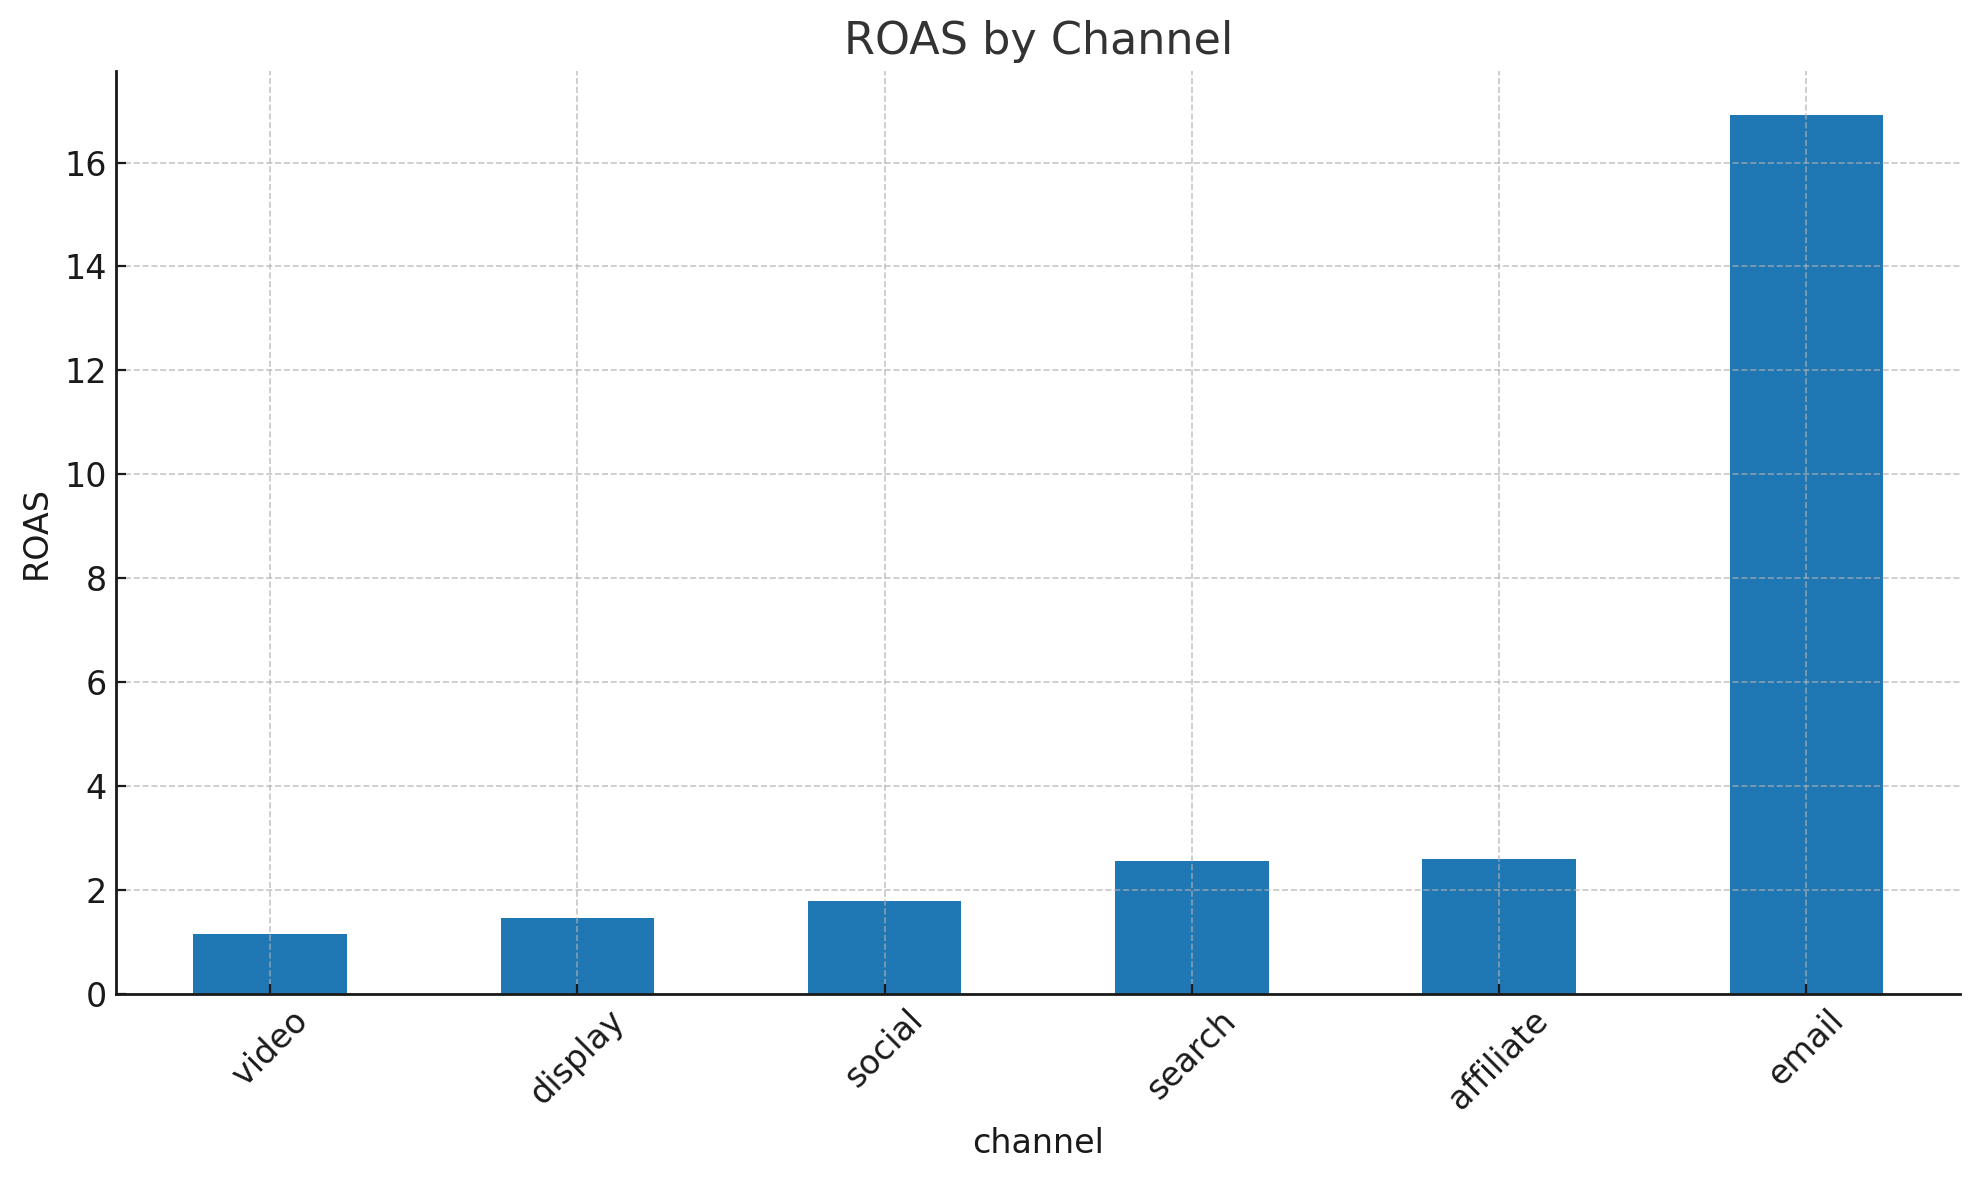

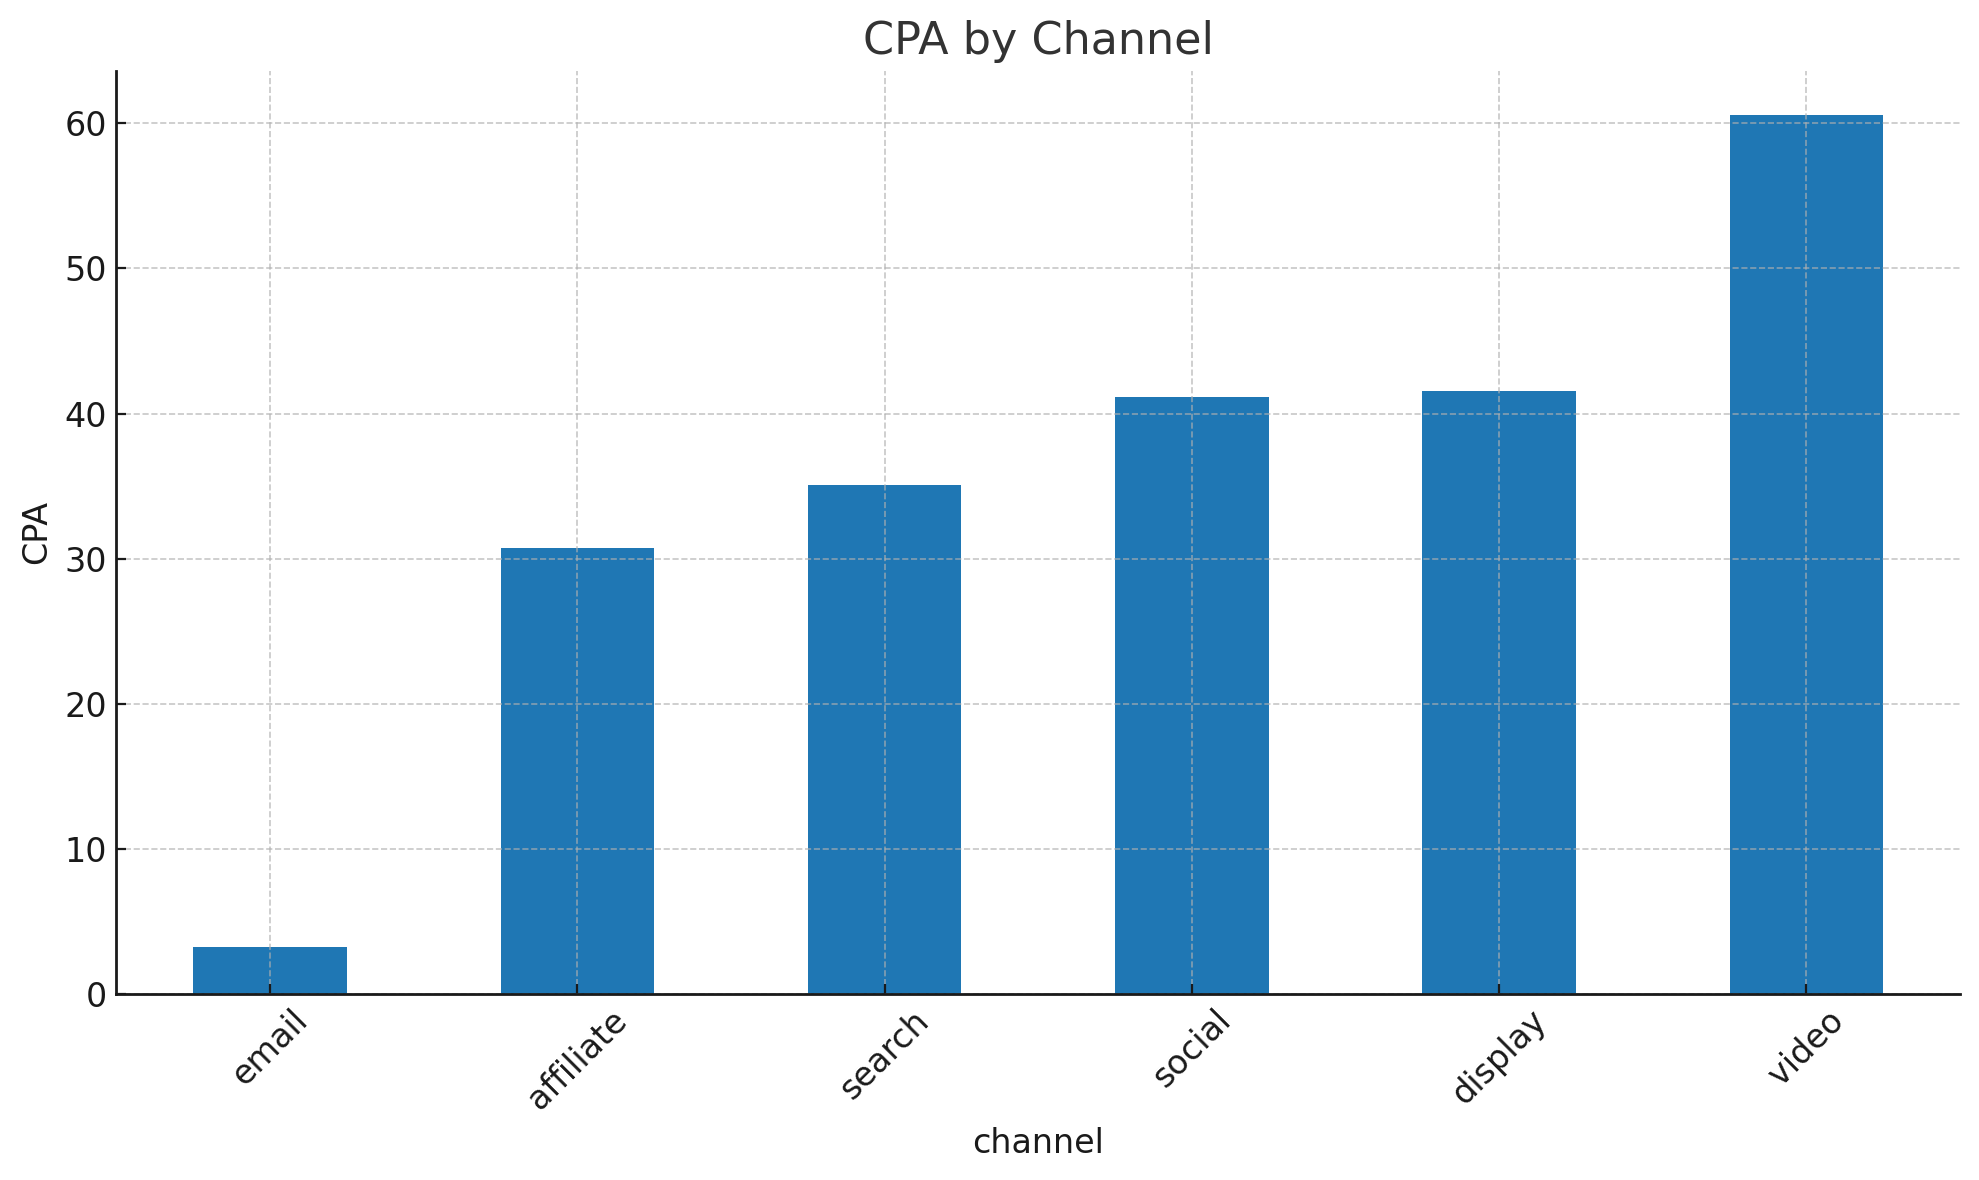

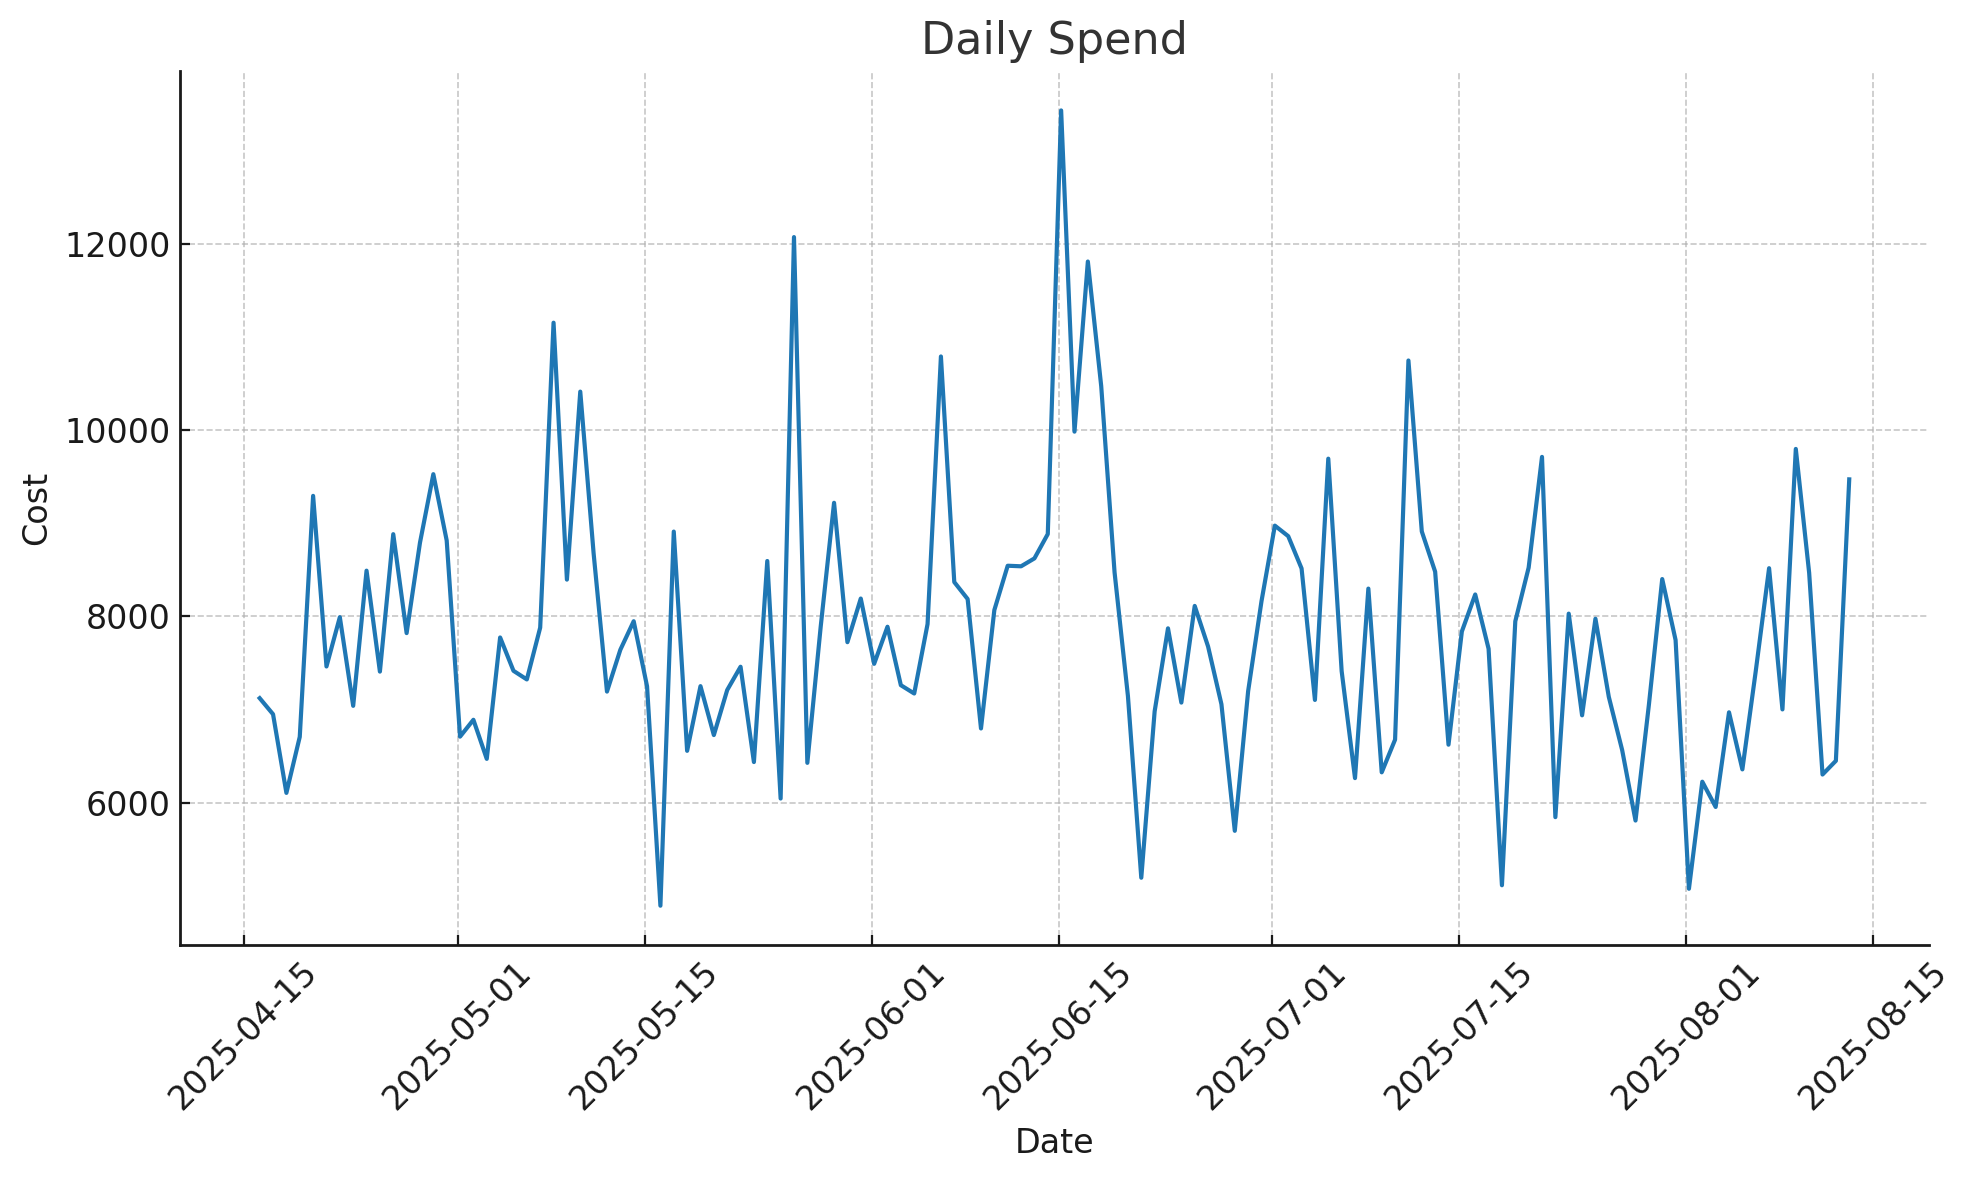

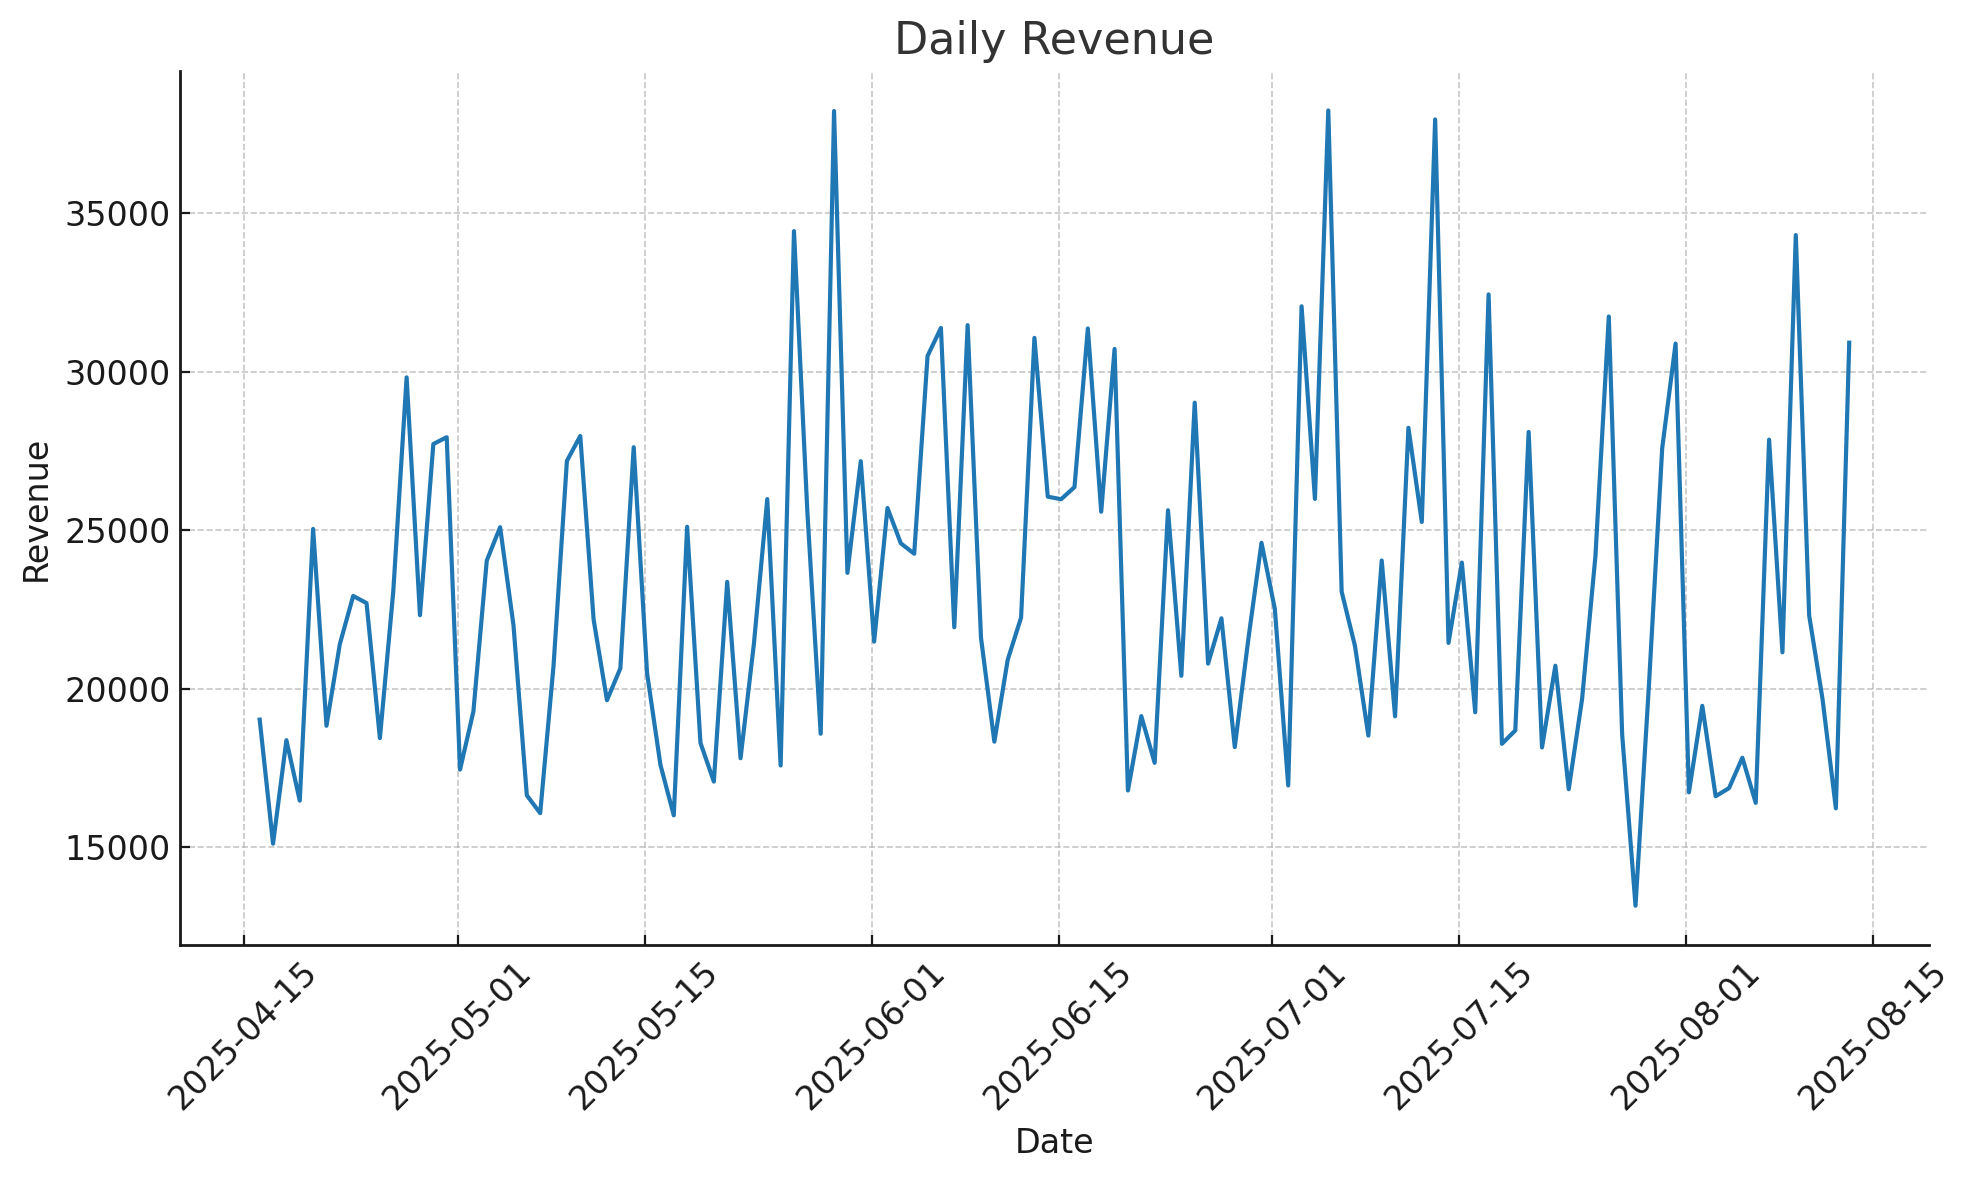

In [2]:
df['ctr'] = df['clicks'] / df['impressions'].replace(0, np.nan)
df['cpc'] = df['cost'] / df['clicks'].replace(0, np.nan)
df['cpa'] = df['cost'] / df['conversions'].replace(0, np.nan)
df['roas'] = df['revenue'] / df['cost'].replace(0, np.nan)

summary = df.groupby('channel')[['impressions','clicks','cost','conversions','revenue']].sum()
summary['ctr'] = summary['clicks']/summary['impressions']
summary['cpc'] = summary['cost']/summary['clicks']
summary['cpa'] = summary['cost']/summary['conversions']
summary['roas'] = summary['revenue']/summary['cost']
print(summary.round(3))

plt.figure()
summary['roas'].sort_values().plot(kind='bar')
plt.title('ROAS by Channel'); plt.ylabel('ROAS'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure()
summary['cpa'].sort_values().plot(kind='bar')
plt.title('CPA by Channel'); plt.ylabel('CPA'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

daily = df.groupby('date')[['cost','revenue']].sum().reset_index()
plt.figure()
plt.plot(daily['date'], daily['cost'])
plt.title('Daily Spend'); plt.xlabel('Date'); plt.ylabel('Cost'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(daily['date'], daily['revenue'])
plt.title('Daily Revenue'); plt.xlabel('Date'); plt.ylabel('Revenue'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


           conversions  clicks       cost     revenue  conv_rate
group                                                           
control          19433  600631  507200.74  1477941.56      0.032
treatment        17617  545740  432101.53  1287419.42      0.032
Relative lift in conversion rate (treatment vs control): -0.23%


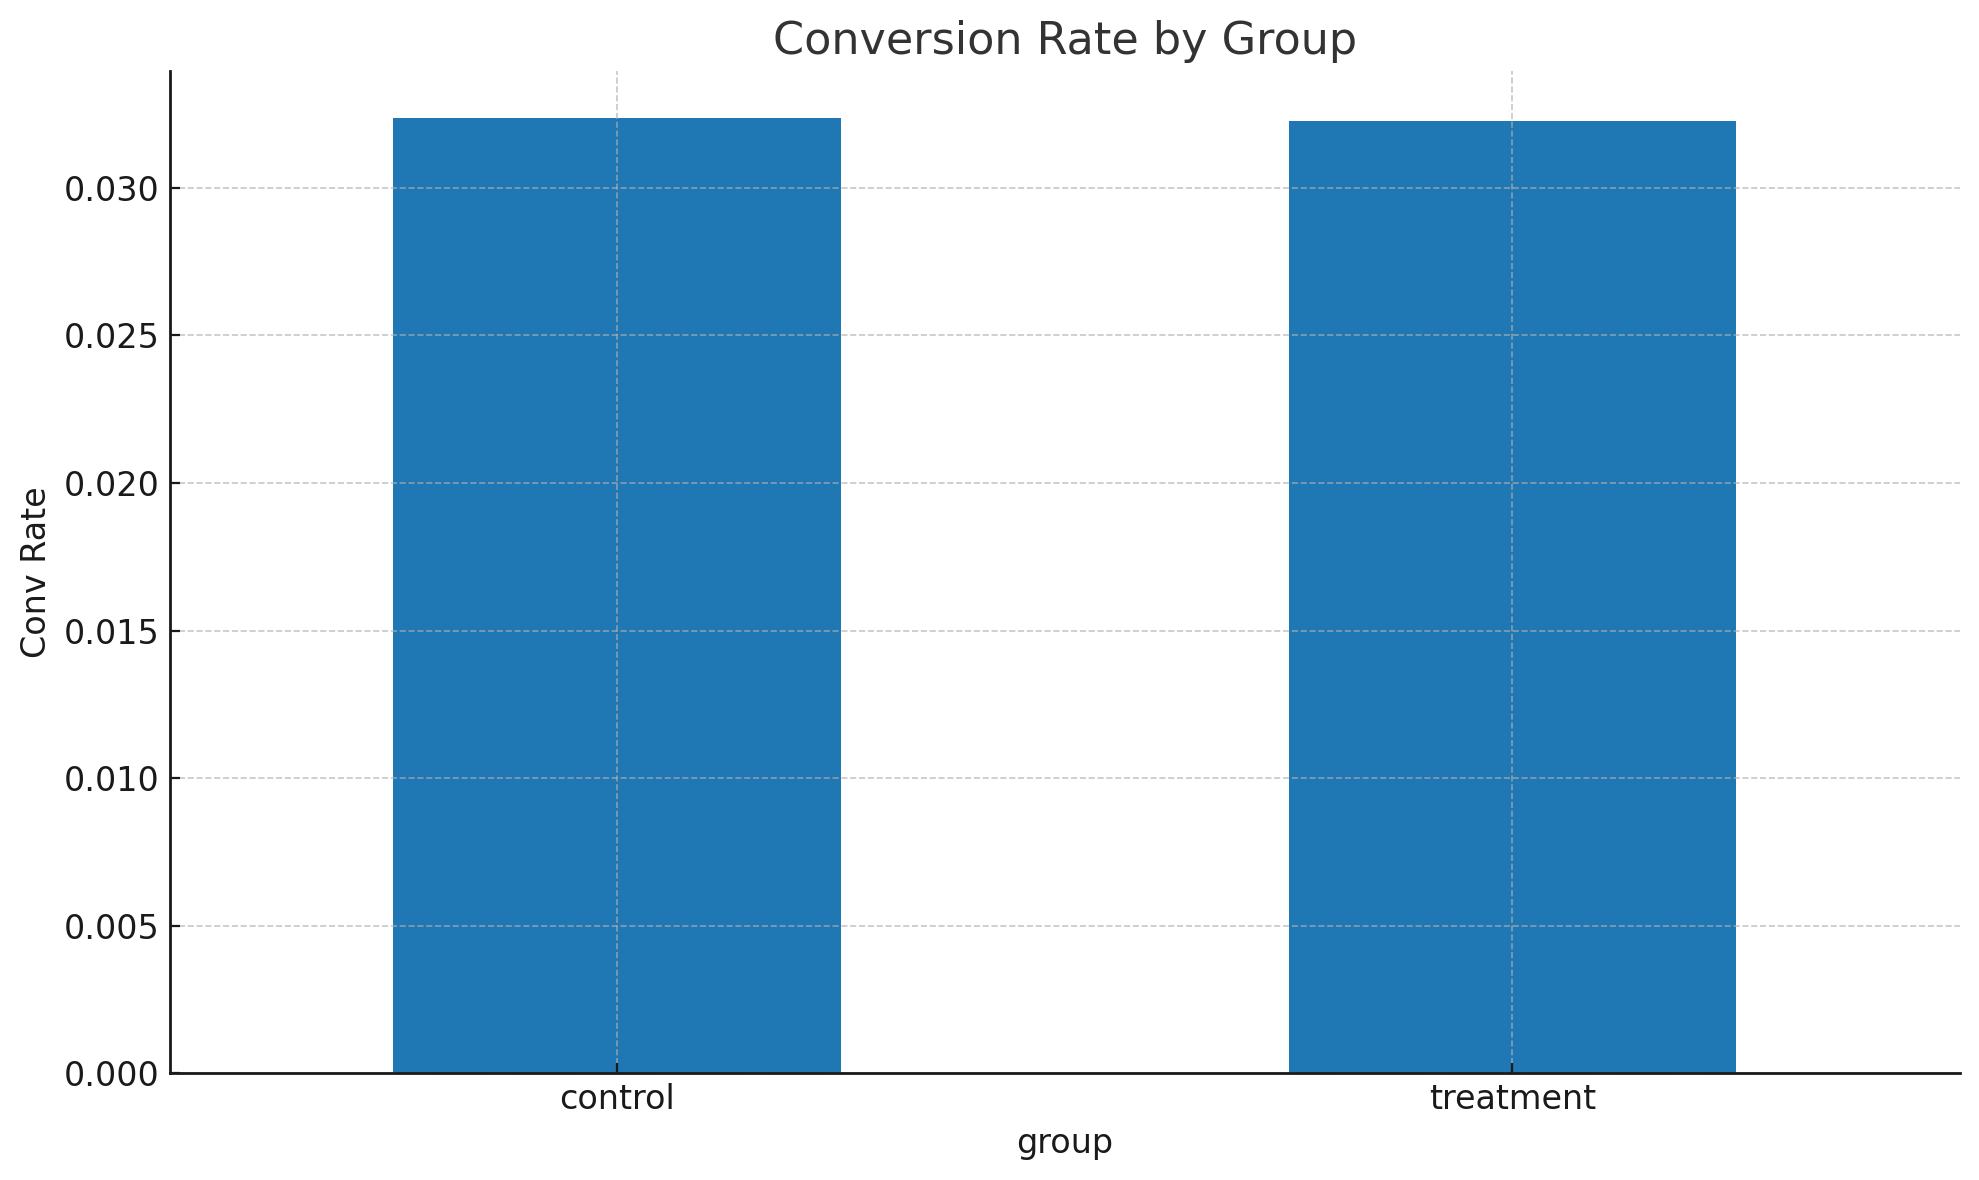

In [3]:
grp = df.groupby('group')[['conversions','clicks','cost','revenue']].sum()
grp['conv_rate'] = grp['conversions'] / grp['clicks'].replace(0, np.nan)
print(grp.round(3))

t_conv, c_conv = grp.loc['treatment','conv_rate'], grp.loc['control','conv_rate']
lift = (t_conv - c_conv) / c_conv
print(f"Relative lift in conversion rate (treatment vs control): {lift:.2%}")

plt.figure()
grp['conv_rate'].plot(kind='bar')
plt.title('Conversion Rate by Group'); plt.ylabel('Conv Rate'); plt.xticks(rotation=0); plt.tight_layout(); plt.show()


           first_touch_conversions  last_touch_conversions
channel                                                   
search                     14427.8                 15255.5
email                       9721.6                  9164.4
social                      6869.1                  6347.7
affiliate                   2528.5                  2496.9
video                       1565.6                  1933.4
display                     1937.4                  1852.2


<Figure size 2000x1200 with 0 Axes>

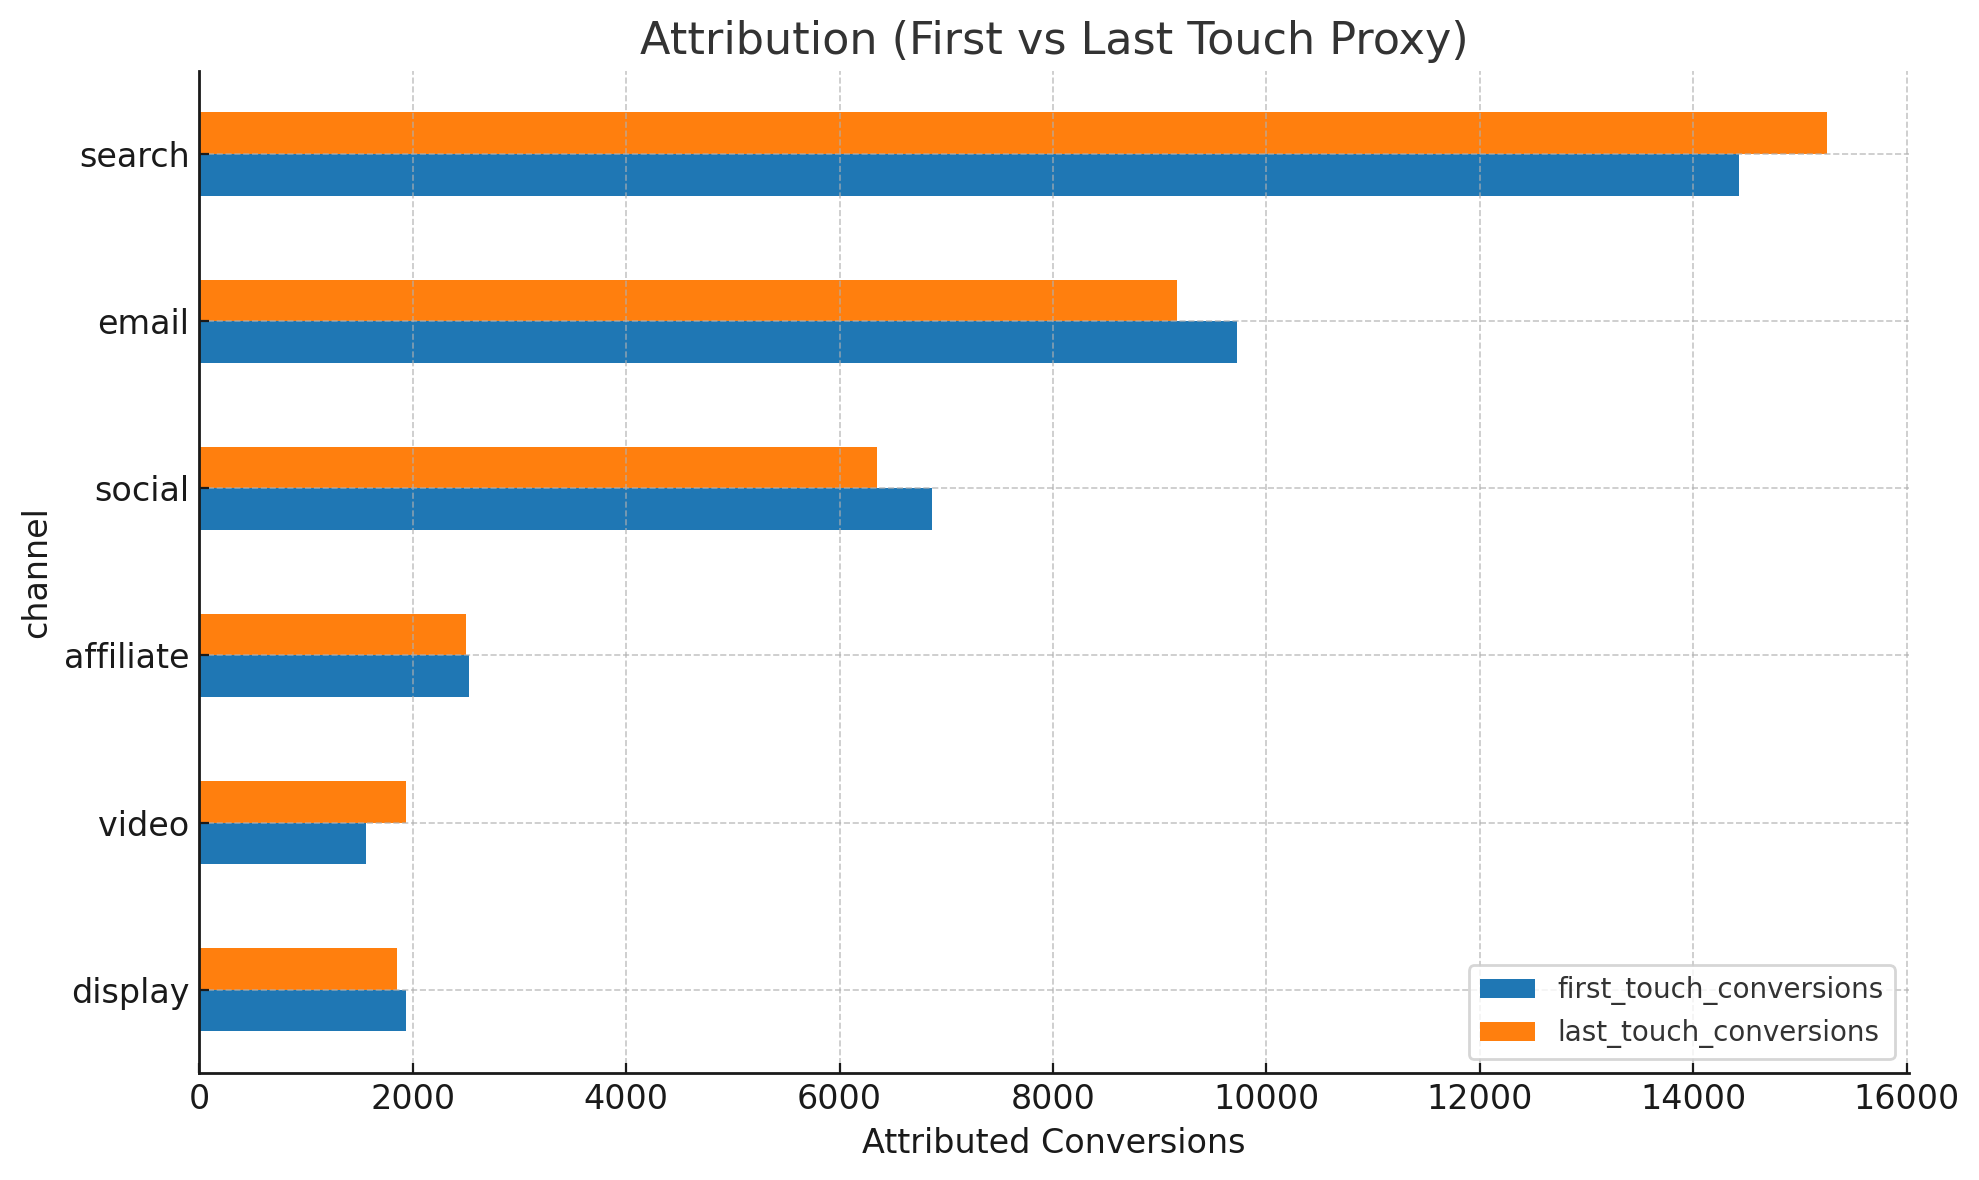

In [4]:
# Naive first vs last touch using click shares in first/last 10 days
daily_channel = df.groupby(['date','channel'])[['clicks','conversions','revenue']].sum().reset_index()

first_window_end = pd.to_datetime(daily_channel['date']).min() + pd.Timedelta(days=9)
last_window_start = pd.to_datetime(daily_channel['date']).max() - pd.Timedelta(days=9)

first_window = daily_channel[pd.to_datetime(daily_channel['date']) <= first_window_end]
last_window = daily_channel[pd.to_datetime(daily_channel['date']) >= last_window_start]

first_shares = first_window.groupby('channel')['clicks'].sum()
first_shares = first_shares / first_shares.sum()

last_shares = last_window.groupby('channel')['clicks'].sum()
last_shares = last_shares / last_shares.sum()

total_conversions = df['conversions'].sum()
attrib_first = (first_shares * total_conversions).fillna(0)
attrib_last = (last_shares * total_conversions).fillna(0)

attrib = pd.DataFrame({'first_touch_conversions': attrib_first.round(1),
                       'last_touch_conversions': attrib_last.round(1)}).fillna(0)

print(attrib.sort_values('last_touch_conversions', ascending=False))

plt.figure()
attrib.sort_values('last_touch_conversions').plot(kind='barh')
plt.title('Attribution (First vs Last Touch Proxy)'); plt.xlabel('Attributed Conversions'); plt.tight_layout(); plt.show()


In [5]:
print("Insights:")
print("- Compare ROAS and CPA side-by-side to prioritize efficient scale.")
print("- Treatment lift (if positive) supports rollout; validate with proper experiment design when possible.")
print("- Naive attribution views can diverge—use MTA or MMM for robust decisions when path data exists.")

Insights:
- Compare ROAS and CPA side-by-side to prioritize efficient scale.
- Treatment lift (if positive) supports rollout; validate with proper experiment design when possible.
- Naive attribution views can diverge—use MTA or MMM for robust decisions when path data exists.
